# Part 1: Data Exploration

In this notebook you will perform your:
- data cleaning
- data exploration
- feature engineering

There is no one, correct, way to structure this notebook and so you may build this notebook out in whatever way is most conducive towards your preferences. At the very minimum, notebook should read in the raw data and output to .csv format your cleaned and prepared data.

To start you off, the variable df has been pre-loaded to have your training dataset. **This is the data that you will use to train and test your model. The file labled "test.tsv" should only be used at the very end of the challenge for your final performance evaluation!** If you would like to know more about this data you can go [here](https://www.kaggle.com/c/sentiment-analysis-on-movie-reviews/overview). We encourage you to look at the 'Overview' and 'Data' tabs; however, we encourage you also to not look at community submissions and to develop your own unique solution from your own research!

In [1]:
import sys
import os
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import spacy
from tqdm import tqdm
%matplotlib inline
os.system("python -m spacy download en_core_web_lg")

# when it comes time to evaluate the model for final scoring, just change this to test.tsv!
df = pd.read_csv('train.csv', index_col=0)
df.head()

,PhraseId,SentenceId,Phrase,Sentiment
0,1,1,A series of escapades demonstrating the adage ...,1
1,2,1,A series of escapades demonstrating the adage ...,2
2,3,1,A series,2
3,4,1,A,2
4,5,1,series,2


One final note: if you are looking for files you export from this notebook, by default (if you don't otherwise assign the path) any files output from this notebook will be placed in the code directory! Good luck on BYTES Challenge II!!

Number of Sentences: 4877
Number of Phrases: 93644
Number of words:
Min: 1 Mean: 19.044084478162805 Max: 52
Number of times a word occurs only once: 6440
Total number of unique words: 12201
Known words ratio: 0.4721744119334481


Text(0.5, 1.0, 'Distribution of number of words in a sentence')

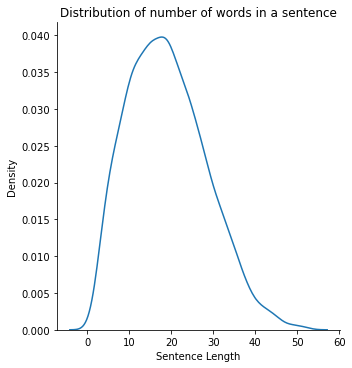

In [2]:
# Print number of samples
print('Number of Sentences:', len(df['SentenceId'].value_counts()))
print('Number of Phrases:', len(df))

# Filter out repeats
reduced = df[['SentenceId', 'Phrase', 'Sentiment']].groupby(by='SentenceId').apply(lambda group: group[group['Phrase'].str.len()==group['Phrase'].str.len().max()])
# Look at length of average sample
reduced['lengths'] = reduced['Phrase'].str.split().str.len()
reduced = reduced.set_index(keys=np.arange(len(reduced)))
print('Number of words:')
print('Min:', reduced['lengths'].min(), 'Mean:', reduced['lengths'].mean(), 'Max:', reduced['lengths'].max())

# Print the size of the vocabulary
words = reduced['Phrase'].str.split(expand=True).melt(value_name='Word').dropna()
words = words[words['Word'].str.isalpha()]['Word'].value_counts()
print('Number of times a word occurs only once:', len(words[words==1]))
print('Total number of unique words:', len(words))
print('Known words ratio:', 1-len(words[words==1])/len(words))

sns.displot(reduced['lengths'], kind='kde') # Weird distrbuiton in bars
plt.xlabel('Sentence Length')
plt.title('Distribution of number of words in a sentence')

Text(0.5, 1.0, 'Distribution of ratings')

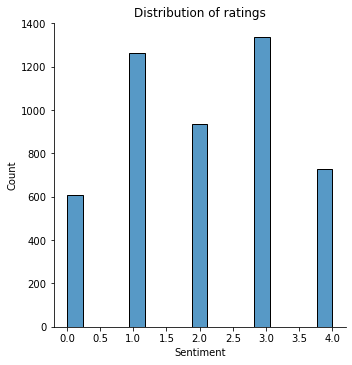

In [3]:
sns.displot(reduced['Sentiment'])
plt.xlabel('Sentiment')
plt.title('Distribution of ratings')

In [4]:
# Confirm that we don't need dropna or anything
print(pd.read_csv('train.csv', index_col=0).info())
print(pd.read_csv('test.csv', index_col=0).info())

<class 'pandas.core.frame.DataFrame'>
Int64Index: 93644 entries, 0 to 93643
Data columns (total 4 columns):
 #   Column      Non-Null Count  Dtype 
---  ------      --------------  ----- 
 0   PhraseId    93644 non-null  int64 
 1   SentenceId  93644 non-null  int64 
 2   Phrase      93644 non-null  object
 3   Sentiment   93644 non-null  int64 
dtypes: int64(3), object(1)
memory usage: 3.6+ MB
None
<class 'pandas.core.frame.DataFrame'>
Int64Index: 62416 entries, 93644 to 156059
Data columns (total 4 columns):
 #   Column      Non-Null Count  Dtype 
---  ------      --------------  ----- 
 0   PhraseId    62416 non-null  int64 
 1   SentenceId  62416 non-null  int64 
 2   Phrase      62416 non-null  object
 3   Sentiment   62416 non-null  int64 
dtypes: int64(3), object(1)
memory usage: 2.4+ MB
None


In [5]:
"""
Conclusions from exploratory analysis:
Because each sentence comes with Sentiment ratings for each separate phrase, that could be used for learning. However, this is unlikely to be
effective since it is does not account for meaning at all.
There's not a ton of samples, so if I train a neural network, I need to be extremely cautious to not overfit.
The length of each sentence indicates that I could use average word vectors or bag of words representation.
The vocabulary is relatively large, meaning I should use a full vocabulary import while preprocessing the data.
Only about half of the words are repeated, so it is unlikely that bag of words would be very effective.

Steps forward:
For this dataset, the obvious choice as to how to preprocess this data is to use average word vectors for the phrase and the length of the
phrase in number of words. I'm interested in comparing the performance of a Linear SVM, a Radial SVM, and PyTorch model. I expect all to perform
rather similarly, since these word vectors have 200 dimensions.
"""

"\nConclusions from exploratory analysis:\nBecause each sentence comes with Sentiment ratings for each separate phrase, that could be used for learning. However, this is unlikely to be\neffective since it is does not account for meaning at all.\nThere's not a ton of samples, so if I train a neural network, I need to be extremely cautious to not overfit.\nThe length of each sentence indicates that I could use average word vectors or bag of words representation.\nThe vocabulary is relatively large, meaning I should use a full vocabulary import while preprocessing the data.\nOnly about half of the words are repeated, so it is unlikely that bag of words would be very effective.\n\nSteps forward:\nFor this dataset, the obvious choice as to how to preprocess this data is to use average word vectors for the phrase and the length of the\nphrase in number of words. I'm interested in comparing the performance of a Linear SVM, a Radial SVM, and PyTorch model. I expect all to perform\nrather simil

In [6]:
# This cell will contain my function definitions for feature cleaning

def avg_vector(data, nlp):
    data['lengths'] = data['Phrase'].str.split().str.len()
    
    with nlp.disable_pipes():
        doc_vectors = np.array([nlp(text).vector for text in tqdm(data['Phrase'])])
    doc_vectors = pd.DataFrame(doc_vectors, index=data.index)
    
    data = data.merge(doc_vectors, left_index=True, right_index=True)
    
    return data

In [7]:
try:
    nlp = spacy.load("en_core_web_lg")
    train_data = pd.read_csv('train.csv', index_col=0)
    preprocessed_train = avg_vector(train_data, nlp)
    preprocessed_train.to_csv('preprocessed_train.csv', index=False)
    print('Finished saving preprocessed training data')
except OSError:
    print('You need to run the import box again. The language module was not downloaded properly.')

100%|██████████| 93644/93644 [10:09<00:00, 153.54it/s]


Finished saving preprocessed training data


In [ ]:
try:
    nlp = spacy.load("en_core_web_lg")
    test_data = pd.read_csv('test.csv', index_col=0)
    preprocessed_test = avg_vector(test_data, nlp)
    preprocessed_test.to_csv('preprocessed_test.csv', index=False)
    print('Finished saving preprocessed testing data')
except OSError:
    print('You need to run the import box again. The language module was not downloaded properly.')

100%|██████████| 62416/62416 [11:09<00:00, 93.18it/s] 
